# API Development

This is already in active development:
https://github.com/lukas-weber/Carlo.jl

In [1]:
using Random 
#########################
# Core Abstractions
#########################
abstract type AbstractSystem end
abstract type AbstractAlgorithm end
abstract type AbstractUpdate end
abstract type AbstractMeasurement end

##########################
# System API
##########################
# for equilibrium simulations
struct NullSystem <: AbstractSystem end

## Measurements (currenlty only for discrete time)

In [2]:
using StatsBase
struct Measurement{F,T}
    observable::F
    data::T  # Vector, Histogram, etc.
end
Measurement(pair::Pair{<:Function}) = Measurement(pair.first, pair.second)
# single measurement
function measure!(measurement::Measurement, sys; kwargs...)
    value = measurement.observable(sys)
    push!(measurement.data, value)
end

# A collection of measurements with intervalled timing
mutable struct Measurements{K}
    measurements::Dict{K, Measurement}
    interval
    _checkpoint
    Measurements(measurements::Dict{K, Measurement}; interval) where K = new{K}(measurements, interval, 0)
end
function Measurements(pairs::Vector{<:Pair{K}}; interval) where K <: Union{Symbol, String}
    measurements = Dict{K, Measurement}(name => Measurement(pair) for (name, pair) in pairs)
    Measurements(measurements, interval=interval)
end
Base.getindex(m::Measurements{K}, key::K) where K = m.measurements[key]
Base.setindex!(m::Measurements{K}, val, key::K) where K = m.measurements[key] = val


# measurement with intervals
function measure!(measurements::Measurements, sys, t; kwargs...)
    if t >= measurements._checkpoint
        for (name, measurement) in measurements.measurements
            measure!(measurement, sys; kwargs...)
        end
        measurements._checkpoint += measurements.interval
    end
end

measure! (generic function with 2 methods)

## Equilibriium

In [3]:
# abstract type ImportanceSampling <: AbstractAlgorithm end
# create basic fields for importance sampling algorithms
abstract type ImportanceSampling <: AbstractAlgorithm end
function log_weight(alg::ImportanceSampling, sys::AbstractSystem, x)
    error("log_weight not implemented for $(typeof(alg)) and $(typeof(sys))")
end

function accept!(alg::ImportanceSampling, sys::AbstractSystem, x_new::T, x_old::T) where T
    alg.steps += 1

    log_weight_diff = log_weight(alg, sys, x_new) - log_weight(alg, sys, x_old)
    accepted = log_weight_diff > 0 || rand(alg.rng) < exp(log_weight_diff)

    alg.accepted += accepted 
    return accepted
end

# If the log_weight is linear in x, we can simply pass the difference
# TODO his is potentially dangerous if misused
function accept!(alg::ImportanceSampling, sys::AbstractSystem, dx::T) where T
    alg.steps += 1

    log_weight_diff = log_weight(alg, sys, dx)
    accepted = log_weight_diff > 0 || rand(alg.rng) < exp(log_weight_diff)

    alg.accepted += accepted 
    return accepted
end

accept! (generic function with 2 methods)

### Example: Distribution sampling

In [4]:
mutable struct Distribution{F} <: AbstractSystem where F
    x :: Any
    logpdf :: F
end

mutable struct DistributionSampling <: ImportanceSampling
    rng :: AbstractRNG
    steps :: Int
    accepted :: Int
    DistributionSampling(rng::AbstractRNG) = new(rng, 0, 0)
end
log_weight(alg::DistributionSampling, sys::Distribution, x) = sys.logpdf(x)

log_weight (generic function with 2 methods)

Acceptance rate: 0.7048451548451549


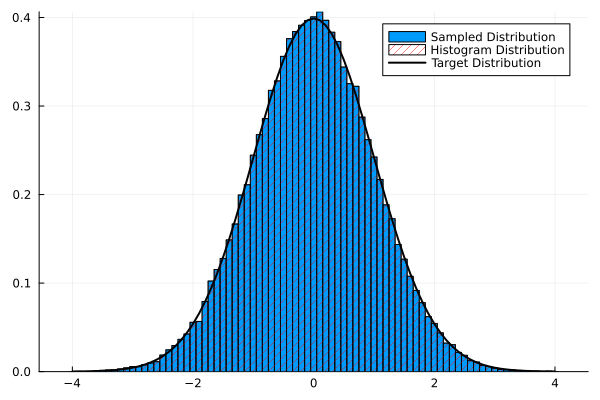

In [5]:
using Random
sys = Distribution(0.0, x -> -x^2/2.0)
alg = DistributionSampling(MersenneTwister(42))

# needs to be defined for each system + algorithm pair
function update!(sys, alg)
    x_old = sys.x
    x_new = x_old + randn(alg.rng) # propose new state
    if accept!(alg, sys, x_new, x_old) 
        sys.x = x_new
    end
end
update!(sys) = update!(sys, alg)

bins = collect(-4.05:0.1:4.05)
measurements = Measurements([
    :timeseries => (sys->sys.x) => Float64[],
    :histogram => (sys->sys.x) => fit(Histogram, Float64[], bins)
], interval=10)

for i in 1:1e3
    # update or next
    update!(sys, alg)
end
for i in 1:1e6
    update!(sys, alg)
    measure!(measurements, sys, i)
end

print("Acceptance rate: ", alg.accepted / alg.steps, "\n")
#plot distribution
using Plots
using Distributions
histogram(measurements[:timeseries].data, bins=bins, normalize=true, label="Sampled Distribution")
meas_dist = StatsBase.normalize(measurements[:histogram].data, mode=:pdf)
plot!(meas_dist, label="Histogram Distribution", alpha=0.5, fillalpha=0.5, fillcolor=:red, fillstyle=:/)
x = -4:0.1:4
plot!(x, pdf.(Normal(0,1), x), label="Target Distribution", color=:black, lw=2)

### Example: Ising

In [6]:
abstract type AbstractSpinSystem <: AbstractSystem end
@inline pick_site(rng, N) = rand(rng, UInt) % N + 1

########################
# general spin flip that would come with SpinSystems
########################
function SpinFlip(sys::AbstractSpinSystem, alg::ImportanceSampling)
    # pick a random spin (from the possible sites -> )
    i = pick_site(alg.rng, length(sys.spins))
    # system knows the possible spin states at site i
    s_new = rand(sys.state)
    E = energy(sys)
    dE = energy_change(sys, i, s_new)

    if accept!(alg, sys, E + dE, E) 
        modify!(sys, i, s_new, dE) #<- modify the system to implement update
    end
end

SpinFlip (generic function with 1 method)

In [ ]:
log_dos_beale_8x8 = [ (-128, 0.6931471805599453), (-124, 0.0), (-120, 4.852030263919617), (-116, 5.545177444479562), (-112, 8.449342524508063), (-108, 9.793672686528922), (-104, 11.887298863200714), (-100, 13.477180596840947), (-96, 15.268195474147658), (-92, 16.912371686315282), (-88, 18.59085846191256), (-84, 20.230089202801466), (-80, 21.870810400320693), (-76, 23.498562234123614), (-72, 25.114602234581373), (-68, 26.70699035290573), (-64, 28.266152815389898), (-60, 29.780704423363996), (-56, 31.241053997806176), (-52, 32.63856452513369), (-48, 33.96613536105969), (-44, 35.217576663643314), (-40, 36.3873411250109), (-36, 37.47007844691906), (-32, 38.46041522581422), (-28, 39.35282710786369), (-24, 40.141667825183845), (-20, 40.82130289691285), (-16, 41.38631975325592), (-12, 41.831753810069756), (-8, 42.153328313883975), (-4, 42.34770636939425), (0, 42.41274640460084), (4, 42.34770636939425), (8, 42.153328313883975), (12, 41.831753810069756), (16, 41.38631975325592), (20, 40.82130289691285), (24, 40.141667825183845), (28, 39.35282710786369), (32, 38.46041522581422), (36, 37.47007844691906), (40, 36.3873411250109), (44, 35.217576663643314), (48, 33.96613536105969), (52, 32.63856452513369), (56, 31.241053997806176), (60, 29.780704423363996), (64, 28.266152815389898), (68, 26.70699035290573), (72, 25.114602234581373), (76, 23.498562234123614), (80, 21.870810400320693), (84, 20.230089202801466), (88, 18.59085846191256), (92, 16.912371686315282), (96, 15.268195474147658), (100, 13.477180596840947), (104, 11.887298863200714), (108, 9.793672686528922), (112, 8.449342524508063), (116, 5.545177444479562), (120, 4.852030263919617), (124, 0.0), (128, 0.6931471805599453) ];
struct BoltzmannDistribution <: ContinuousUnivariateDistribution
    pdf::Dict{Any,Float64}
    function log_sum(a::Number, b::Number)::Float64
        if b < a
            return a + log(1 + exp(b - a))
        else
            return b + log(1 + exp(a - b))
        end
    end
    function initialize_BoltzmannDistribution(beta, log_dos)
        # partition sum
        log_Z = -Inf
        for (E, log_d) in log_dos
            log_Z = log_sum(log_Z, log_d - beta * E)
        end

        pdf = Dict{Int64,Float64}()
        for (E, log_d) in log_dos
            log_pdf = log_d - beta * E - log_Z
            pdf[E] = exp(log_pdf)
        end
        return pdf
    end
    BoltzmannDistribution(beta, log_dos) = new(initialize_BoltzmannDistribution(beta, log_dos))
end

In [63]:
##########################
# Ising
##########################
using Graphs
# TODO: generalize to H = - \sum J_{ij}s_i s_j + mu \sum_i h_i s_i
# and work our way from there?
mutable struct Ising{T} <: AbstractSpinSystem   
    spins :: Vector{Int8}            # ±1
    graph :: SimpleGraph
    nbrs  :: Vector{Vector{Int}}    # precomputed neighbors
    J     :: T
    sum_pairs :: Int                # sum of s_i s_j over edges
    sum_spins :: Int                # sum of spins

    function Ising(graph::SimpleGraph, J)
        T = typeof(J)
        nbrs = [collect(Graphs.neighbors(graph, i)) for i in 1:nv(graph)]

        # all spins = +1 ⇒ each pair contributes +1
        spins = ones(Int8, nv(graph))
        sum_pairs = ne(graph)
        sum_spins = nv(graph)

        new{T}(spins, graph, nbrs, J, sum_pairs, sum_spins)
    end
end
# Convenience lattice constructor
function Ising(dims::Vector{Int}; J=1, periodic=true)
    graph = Graphs.SimpleGraphs.grid(dims; periodic)
    return Ising(graph, J)
end
@inline function _local_spin_pairs(sys::Ising, i)
    s = sys.spins[i]
    acc = 0
    for j in sys.nbrs[i]
        acc += s * sys.spins[j]
    end
    return acc
end

function init(sys::Ising, type::Symbol, rng=nothing)
    if type == :up
        sys.spins .= 1
        sys.sum_pairs = ne(sys.graph)
        sys.sum_spins = length(sys.spins)
    elseif type == :down
        sys.spins .= -1
        sys.sum_pairs = ne(sys.graph)
        sys.sum_spins = -length(sys.spins)
    elseif type == :random
        @assert rng !== nothing
        for i in eachindex(sys.spins)
            sys.spins[i] = rand(rng, Bool) ? 1 : -1
        end
        # recompute bookkeeping
        sum_pairs = zero(sys.J)
        for i in 1:length(sys.spins)
            sum_pairs += _local_spin_pairs(sys, i)
        end
        sys.sum_pairs = sum_pairs/2
        sys.sum_spins = sum(sys.spins)
    end
    return sys
end

# ------------------------------------------------------------
# Observables
# ------------------------------------------------------------

@inline magnetization(sys::Ising) = abs(sys.sum_spins)
@inline energy(sys::Ising) = -sys.J * sys.sum_pairs

@inline energy_change(sys::Ising, i) =
    2 * sys.J * _local_spin_pairs(sys, i)

# for spin updates
@inline function modify!(sys::Ising, i, dE)
    old = sys.spins[i]
    new = -old
    sys.spins[i] = new

    # bookkeeping 
    sys.sum_pairs -= dE / sys.J 
    sys.sum_spins += 2 * new

    return nothing
end

function SpinFlip(sys::Ising, alg::ImportanceSampling)
    i = rand(1:length(sys.spins))
    dE = energy_change(sys, i)

    if accept!(alg, sys, dE) 
        modify!(sys, i, dE)
    end
end

SpinFlip (generic function with 2 methods)

In [64]:
###########################
# Specific Metropolis
###########################
mutable struct Metropolis <: ImportanceSampling
    rng :: AbstractRNG
    beta :: Real
    steps :: Int
    accepted :: Int
    Metropolis(rng::AbstractRNG; beta::Real) = new(rng, beta, 0, 0)
end
log_weight(alg::Metropolis, sys::AbstractSystem, x) = -alg.beta * x 

log_weight (generic function with 3 methods)

In [72]:
using Random 
rng = MersenneTwister(42)
sys = Ising([8,8])
init(sys, :random, rng)
alg = Metropolis(rng, beta=0.3)

measurements = Measurements([
    :energy => energy => Float64[],
    :magnetization => magnetization => Float64[]
], interval=10)

# thermalization
N = nv(sys.graph)
println("Total spins: ", N)

# benchmark the spinflip here
using BenchmarkTools
@btime SpinFlip(sys, alg)

for i in 1:N*1e3
    SpinFlip(sys, alg)
end

# measurement
for i in 1:N*1e4
    SpinFlip(sys, alg)
    measure!(measurements, sys, i)
end

# print results
println("Acceptance rate: ", alg.accepted / alg.steps)
println("Average energy: ", mean(measurements[:energy].data)/N)
println("Average magnetization: ", mean(measurements[:magnetization].data)/N)


Total spins: 64
  218.840 ns (8 allocations: 138 bytes)
Acceptance rate: 0.519724420199235
Average energy: -0.7141128654239778
Average magnetization: 0.2761880673739473


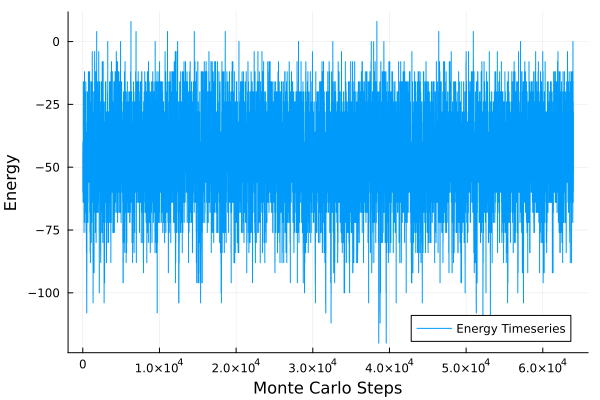

In [73]:
# plot timeseries
using Plots
energies = measurements[:energy].data
plot(energies, label="Energy Timeseries", xlabel="Monte Carlo Steps", ylabel="Energy")

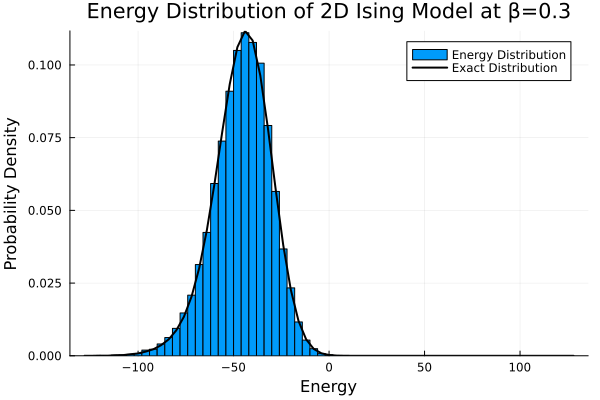

In [74]:
# plot distribution of energy compared to exact
using Plots
energies = measurements[:energy].data
hist = fit(Histogram, energies, minimum(energies)-2:4:maximum(energies)+2, closed=:left)
dist = StatsBase.normalize(hist, mode=:probability)
plot(dist, label="Energy Distribution", xlabel="Energy", ylabel="Probability Density",
    title="Energy Distribution of 2D Ising Model at β=$(alg.beta)")
# exact histogram
P_true = BoltzmannDistribution(alg.beta, log_dos_beale_8x8).pdf
E_vals = sort(collect(keys(P_true)))
P_vals = [P_true[E] for E in E_vals]
plot!(E_vals, P_vals, label="Exact Distribution", color=:black, lw=2)

## Example: Sweep

In [11]:
sys = BlumeCapel(L=10,J=1,d=2)
rng = MersenneTwister(42) # should this be shared between the algs?
alg = Metropolis(rng, beta=1.0) 

# the update function defines all the dynamics (links system and algorithm)
function SpinFlip(sys::BlumeCapel, alg::ImportanceSampling)
    # pick a random spin
    i = rand(1:sys.N)
    # this would need to be adapted for other algorithms e.g. PT in sub energy
    s_old = sys.spins[i]
    s_new = rand([-1,0,1])
    dE = sys.dE(i, s_new, s_old)
    # pass to importance sampling algorithm
    if accept!(alg, sys, dE) # accept stores the acceptance rate etc in the algorithm
        sys.spins[i] = s_new
    end
end

function update!(sys::BlumeCapel)
    ClusterUpdate(alg.rng, sys, version="Wolff")
    # then MC with single spin flips
    for n in 1:3*sys.N
        SpinFlip(sys, alg)
        # Alternative
        #alg(sys, SpinFlip)
    end
end

# thermalization
for i in 1:1e3
    update!(sys)
end
# measurement
for i in 1:1e4
    update!(sys)
    measure!(sys, i; interval=10)
end

UndefVarError: UndefVarError: `BlumeCapel` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Example: Muca

In [12]:
sys = BlumeCapel(L=10,J=1,d=2) 
# requirements
# - possible states (e.g. [-1,0,1]) and sites (e.g. 1:N) (in case of diluted lattices [...])
# - current estimate of energy for update?
# - energy_change function
rng = MersenneTwister(42)

energy(sys::BlumeCapel) = (sys.E_J, sys.E_D)
function energy_change(sys::BlumeCapel, i, s_new)
    # compute energy change for flipping spin at site i
    s_old = sys.spins[i]
    # calculate energy difference spin-spin and crystal field
    dE_J = 0.0
    for j in sys.neighbors[i]
        dE_J += (s_new - s_old) * sys.spins[j]
    end
    dE_D = s_new^2 - s_old^2
    return (dE_J, dE_D)
end
function modify!(sys::BlumeCapel, i, s_new, dE)
    # modify the system to implement update
    sys.spins[i] = s_new
    sys.E_J += dE[1]
    sys.E_D += dE[2]
end

alg = Multicanonical(rng, log_weight=zeros(sys.N), beta = 1.0) #<- mutable
log_weight(alg, sys, E) = -alg.beta * sys.J * E[1] + alg.log_weight[E[2]]

sweep = sys.N
measurements = [
    Histogram([()->energy(sys)[1]], interval=1),
    Timeseries([:energy, :magnetization], interval=sweep)
]

# thermalization
for i in 1:1e3
    SpinFlip(sys, alg)
end

# measurement: measure the energy histogram every step; but observables only during final step (then however in parallel). How can I add multiple measure functions easily?
for i in 1:1e4*sweep
    SpinFlip(sys, alg)
    measure!(measurements, sys, i) # <- select measurements depending on iteration or production
end

UndefVarError: UndefVarError: `BlumeCapel` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Example: PT

In [13]:
sys = Ising(L=10,J=1,d=2)
rng = MersenneTwister(42)
alg = ParallelTempering(rng, betas=[0.5, 1.0, 1.5, 2.0])
# ReplicaExchange(rng, weights=[...])
# ParallelTempering = ReplicaExchange 

# the update function defines all the dynamics (links system and algorithm)
function SpinFlip(sys::Ising, alg::ReplicaExchange)
    # pick a random spin
    i = rand(1:sys.N)
    # this would need to be adapted for other algorithms e.g. PT in sub energy
    dE = sys.dE(i)
    # pass to importance sampling algorithm
    if accept!(alg, sys, dE) # accept stores the acceptance rate etc in the algorithm
        sys.spins[i] = -sys.spins[i] # flip spin
    end
end
update!(sys) = SpinFlip(sys, alg, 0)

# TODO: add replica exchange step every n steps and parallel structure!

sim = Simulation(sys, update!)

# thermalization
run!(sim, 100)  
# measurement
run!(sim, 1e4, measure!)

MethodError: MethodError: no method matching Ising(; L::Int64, J::Int64, d::Int64)
The type `Ising` exists, but no method is defined for this combination of argument types when trying to construct it.

Closest candidates are:
  Ising(!Matched::Vector{Int64}; J, periodic) got unsupported keyword arguments "L", "d"
   @ Main ~/.julia/dev/MonteCarloX/examples/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X15sZmlsZQ==.jl:26
  Ising(!Matched::SimpleGraph, !Matched::Any) got unsupported keyword arguments "L", "J", "d"
   @ Main ~/.julia/dev/MonteCarloX/examples/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X15sZmlsZQ==.jl:13


## Example: Gillespie

In [14]:
sys = ReactionSystem()
alg = Gillespie()

function modify!(sys, event) 
    t, id = event
    # change system state
end

T=1e3
t=0.0
while t < T
    dt, id = next(sys, alg)
    t += dt
    # do measurement if t_meas < t 
    measure!(sys, t)
    # modify system state
    modify!(sys, (t, id))
end


UndefVarError: UndefVarError: `ReactionSystem` not defined in `Main`
Suggestion: check for spelling errors or missing imports.